# Temperature forecast for the general public (MAELSTROM-A1 dataset)

This dataset contains temperature weather forecast for the Nordic region, and are used to produce public weather forecasts on the weather app Yr (www.yr.no). The goal of the prediction task is to generate a deterministic temperature forecast together with an uncertainty range (10% to 90%) as shown here: https://www.yr.no/en/details/graph/5-18700/Norway/Oslo/Oslo/Oslo%20(Blindern).

The target field in the dataset is constructed using a high density network of citizen weather stations from Netatmo.

The current operational implementation uses a very simple regression model based on only a subset of the predictors available in the dataset. It is described in this article: https://journals.ametsoc.org/view/journals/bams/101/1/bams-d-18-0237.1.xml


## Prerequisites
To run this example, you need the following packages:

`pip install climetlab climetlab_maelstrom_a1`

## Loading the data
We can use climetlab to load the dataset into an xarray dataset. There will be several datasets available of different sizes: 300 MB (not available yet), 5GB, and 5TB (not available yet). The 5TB dataset contains the entire Nordic domain at 1x1 km resolution for all 60 hour leadtimes. The 5GB dataset contains only a subset of grid points (128x128) surrounding Oslo, Norway and only for leadtimes 6, 12, ..., 42 hours. All datasets contain the same input predictors and time period (4 years).

Currently, only "air_temperature" is available as the predictand parameter, however precipitation_amount will be added in the future.

The entire 5GB dataset will take a few minutes to load. To only load a subset, add a dates argument to load_dataset, e.g. `dates=['2017-01-01', '2017-01-02']` or `dates=pandas.date_range(start="2017-01-01", end="2017-03-01", freq="1D")`.

In [1]:
import climetlab as cml
cmlds = cml.load_dataset(
        'maelstrom-a1',
        size='5GB',
        parameter='air_temperature',
    )
ds = cmlds.to_xarray()

By downloading data from this dataset, you agree to the terms and conditions defined at https://github.com/metno/maelstrom_a1/LICENSE. If you do not agree with such terms, do not download the data. 


  0%|          | 0/1457 [00:00<?, ?it/s]

This dataset contains the following dimensions and variables

In [2]:
print(ds)

<xarray.Dataset>
Dimensions:             (record: 1457, x: 128, y: 128, leadtime: 8, predictor: 49, char: 50)
Coordinates:
  * x                   (x) float32 -2.974e+05 -2.964e+05 ... -1.704e+05
  * y                   (y) float32 -5.043e+05 -5.033e+05 ... -3.773e+05
  * leadtime            (leadtime) timedelta64[ns] 00:00:00 ... 1 days 18:00:00
    latitude            (y, x) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
    longitude           (y, x) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
Dimensions without coordinates: record, predictor, char
Data variables:
    time                (record) datetime64[ns] 2017-01-01 ... 2020-12-31
    projection          int32 -2147483647
    altitude            (y, x) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
    predictors          (record, y, x, predictor) float32 dask.array<chunksize=(1, 128, 128, 49), meta=np.ndarray>
    leadtime_predictor  (predictor) timedelta64[ns] dask.array<chunksize=(49,), m

The record dimensions

### Plotting predictors and predictand (target)

In [3]:
import matplotlib.pyplot as plt
import numpy as np

names = ds["name_predictor"].values
names = np.array([''.join([qq.decode('utf-8') for qq in names[p, :]]) for p in range(names.shape[0])])

num_leadtimes = len(ds["leadtime"])

unique_predictor_names = np.unique(names)
print("Available predictors:", unique_predictor_names)


Available predictors: ['air_temperature_2m' 'bias_recent' 'bias_yesterday' 'cloud_area_fraction'
 'precipitation_amount' 'x_wind_10m' 'y_wind_10m']


Text(0.5, 1.0, 'Target')

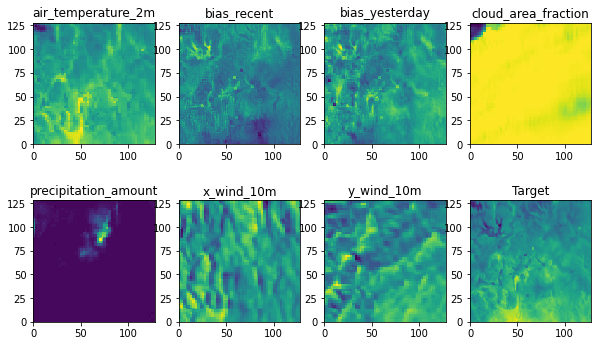

In [4]:
index_date = 0
predictors = ds["predictors"].values
target = ds["target"].values
for i, name in enumerate(unique_predictor_names):
    plt.subplot(2, 4, i + 1)
    index = np.where(names == name)[0][0]
    plt.pcolormesh(predictors[index_date, :, :, index], shading="auto")
    plt.gca().set_aspect(1)
    plt.title(name)
plt.subplot(2, 4, 8)
plt.pcolormesh(target[index_date, :, :, 0], shading="auto")
plt.gca().set_aspect(1)
plt.gcf().set_size_inches(10, 6)
plt.title("Target")

## Example solution
### Normalizing the predictors

In [5]:
raw = np.copy(ds["predictors"][:, :, :, 0:8])
P = ds["predictors"].shape[3]
for p in range(P):
    print(p)
    ds["predictors"][:, :, :, p] -= np.nanmean(ds["predictors"][:, :, :, p])
    ds["predictors"][:, :, :, p] /= np.nanstd(ds["predictors"][:, :, :, p])

KeyboardInterrupt: 

### Defining the loss function
We use the quantile loss function, by scoring each of the three output quantiles of the model:

In [27]:
global num_leadtimes
def quantile_loss_function(y_true, y_pred):
    err0 = y_true - y_pred[:, :, :, 0:num_leadtimes]
    err1 = y_true - y_pred[:, :, :, num_leadtimes:(2*num_leadtimes)]
    err2 = y_true - y_pred[:, :, :, (2*num_leadtimes):(3*num_leadtimes)]
    qtloss0 = (0.5 - tf.cast((err0 < 0), tf.float32)) * err0
    qtloss1 = (0.1 - tf.cast((err1 < 0), tf.float32)) * err1
    qtloss2 = (0.9 - tf.cast((err2 < 0), tf.float32)) * err2
    return K.mean(qtloss0 + qtloss1 + qtloss2)

20200104T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20200105T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20200106T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20200108T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20200107T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

### Setting up the model
The model takes a gridded predictor set as input and outputs gridded fields for each leadtime and for three quantiles. The tempearture forecast on yr.no has both a deterministic best guess and a 10-90% confidence interval. We want the model to predict all three parameters simultaneously.

In [8]:
import keras
import tensorflow as tf
import keras.backend as K

num_outputs = 3 * 8
model = keras.Sequential()
model.add(keras.layers.InputLayer(predictors.shape[1:]))
model.add(keras.layers.Dense(24))
model.add(keras.layers.Conv2D(24, 3, activation = 'relu', padding = 'same'))
model.add(keras.layers.Dense(24))
model.add(keras.layers.Dense(num_outputs))

model.compile(optimizer = keras.optimizers.Adam(learning_rate = 1e-4), loss = quantile_loss_function)

2021-07-28 13:08:01.863724: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/thomasn/local/lib
2021-07-28 13:08:01.863747: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-07-28 13:08:02.966631: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/thomasn/local/lib
2021-07-28 13:08:02.966664: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-07-28 13:08:02.966687: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pc5088): /proc/driver/nvidia/version d

### Training the model

In [9]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss=quantile_loss_function)
num_epochs = 50
batch_size = 4
model.fit(predictors, target, epochs=num_epochs, batch_size=batch_size)

/home/thomasn/.local/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2021-07-28 13:08:03.216659: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-28 13:08:03.237308: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2099940000 Hz


Epoch 1/50
1/1 [==============================] - 8s 8s/step - loss: 4.8473
Epoch 2/50
1/1 [==============================] - 0s 26ms/step - loss: 3.7336
Epoch 3/50
1/1 [==============================] - 0s 27ms/step - loss: 2.9842
Epoch 4/50
1/1 [==============================] - 0s 27ms/step - loss: 2.4802
Epoch 5/50
1/1 [==============================] - 0s 30ms/step - loss: 2.2245
Epoch 6/50
1/1 [==============================] - 0s 31ms/step - loss: 1.9165
Epoch 7/50
1/1 [==============================] - 0s 30ms/step - loss: 1.6858
Epoch 8/50
1/1 [==============================] - 0s 28ms/step - loss: 1.6476
Epoch 9/50
1/1 [==============================] - 0s 28ms/step - loss: 1.4582
Epoch 10/50
1/1 [==============================] - 0s 31ms/step - loss: 1.4351
Epoch 11/50
1/1 [==============================] - 0s 30ms/step - loss: 1.3710
Epoch 12/50
1/1 [==============================] - 0s 27ms/step - loss: 1.2562
Epoch 13/50
1/1 [==============================] - 0s 27ms/step

### Predict output

In [10]:
output = model.predict(predictors)

## Model evaluation and visualization

### Evaluating the model
First, lets compare the mean absolute error of the raw forecast and the ML-forecast of the median

In [13]:
print("Raw model MAE:", np.nanmean(np.abs(raw - target)), "°C")
print("ML MAE:", np.nanmean(np.abs(output[:, :, :, 0:8] - target)), "°C")

Raw model MAE: 0.7934417 °C
ML MAE: 0.5860007 °C


Next, we can plot the MAE as a function of leadtime:

Text(0, 0.5, 'Mean absolute error (°C)')

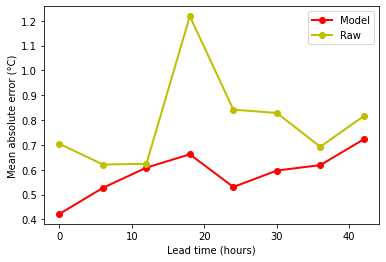

In [14]:
plt.plot(x, [np.nanmean(np.abs(output[:, :, :, i] - target[:, :, :, i])) for i in range(num_leadtimes)], 'ro-', lw=2, label="Model")
plt.plot(x, [np.nanmean(np.abs(raw[:, :, :, i] - target[:, :, :, i])) for i in range(num_leadtimes)], 'yo-', lw=2, label="Raw")
plt.legend()
plt.xlabel("Lead time (hours)")
plt.ylabel("Mean absolute error (°C)")


### Visualizing the results as timeseries
We can visualize the output as a timeseries. We will pick an example point (Oslo).

In [ ]:
x = ds["leadtime"].astype(float) / 3600 / 1e9
Y = 55
X = 55
plt.plot(x, output[0, Y, X, 0:num_leadtimes], 'r-', lw=2, label="Median")
plt.plot(x, raw[0, Y, X, 0:num_leadtimes], 'y-', lw=2, label="Raw")
lower = output[0, Y, X,num_leadtimes:2*num_leadtimes]
upper = output[0, Y, X, 2*num_leadtimes:3*num_leadtimes]
plt.plot(x, lower, 'r--', lw=2, label="10%")
plt.plot(x, upper, 'r--', lw=2, label="90%")
xx = np.concatenate((x, x[::-1]))
plt.fill(np.concatenate((x, x[::-1])), np.concatenate((lower, upper[::-1])), color='r', alpha=0.2, linewidth=0)
plt.plot(x, target[0, Y, X, :], 'bo-', lw=2, label="Target")
plt.legend()
plt.xlabel("Lead time (hours)")
plt.ylabel("Air temperature (°C)")
plt.gcf().set_size_inches(10, 6)

20180915T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20180916T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20180917T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20180918T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20180919T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20180920T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20180921T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20180922T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20180923T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20180924T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20180925T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20180926T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20180927T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20180928T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20180930T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20180929T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181001T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181002T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181003T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181004T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181005T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181006T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181007T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181008T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181009T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181010T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181011T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181012T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181013T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181014T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181015T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181016T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181017T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181018T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181020T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181021T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181019T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181023T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181022T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181024T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181025T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181026T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181027T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181028T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181029T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181031T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

('Connection aborted.', OSError(0, 'Error'))


20181101T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181102T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181103T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181104T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181105T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181106T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181107T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181108T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181109T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181110T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181111T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181113T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181112T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181114T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181115T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181116T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181117T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181119T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181121T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181118T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181123T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181120T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]


('Connection aborted.', OSError(0, 'Error'))


20181124T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181125T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181126T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181127T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181128T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181201T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

HEAD https://storage.ecmwf.europeanweather.cloud/MAELSTROM_AP1/air_temperature_5GB/20181129T00Z.nc
Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/urllib3/connectionpool.py", line 598, in urlopen
    httplib_response = self._make_request(conn, method, url,
  File "/usr/lib/python3/dist-packages/urllib3/connectionpool.py", line 346, in _make_request
    self._validate_conn(conn)
  File "/usr/lib/python3/dist-packages/urllib3/connectionpool.py", line 852, in _validate_conn
    conn.connect()
  File "/usr/lib/python3/dist-packages/urllib3/connection.py", line 333, in connect
    self.sock = ssl_wrap_socket(
  File "/usr/lib/python3/dist-packages/urllib3/util/ssl_.py", line 332, in ssl_wrap_socket
    return context.wrap_socket(sock, server_hostname=server_hostname)
  File "/usr/lib/python3.8/ssl.py", line 500, in wrap_socket
    return self.sslsocket_class._create(
  File "/usr/lib/python3.8/ssl.py", line 1040, in _create
    self.do_handshake()
  File "/usr/lib/

20181129T00Z.nc: 0.00B [00:00, ?B/s]

20181130T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181203T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181204T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181206T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]



HEAD https://storage.ecmwf.europeanweather.cloud/MAELSTROM_AP1/air_temperature_5GB/20181202T00Z.nc
Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/urllib3/connectionpool.py", line 598, in urlopen
    httplib_response = self._make_request(conn, method, url,
  File "/usr/lib/python3/dist-packages/urllib3/connectionpool.py", line 346, in _make_request
    self._validate_conn(conn)
  File "/usr/lib/python3/dist-packages/urllib3/connectionpool.py", line 852, in _validate_conn
    conn.connect()
  File "/usr/lib/python3/dist-packages/urllib3/connection.py", line 333, in connect
    self.sock = ssl_wrap_socket(
  File "/usr/lib/python3/dist-packages/urllib3/util/ssl_.py", line 332, in ssl_wrap_socket
    return context.wrap_socket(sock, server_hostname=server_hostname)
  File "/usr/lib/python3.8/ssl.py", line 500, in wrap_socket
    return self.sslsocket_class._create(
  File "/usr/lib/python3.8/ssl.py", line 1040, in _create
    self.do_handshake()
  File "/usr/li

20181207T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181202T00Z.nc: 0.00B [00:00, ?B/s]

20181205T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181208T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181210T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181212T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181211T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181213T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181214T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181209T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181215T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181216T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181217T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181218T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181219T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181220T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181221T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181222T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181223T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181224T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181225T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181226T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181227T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181228T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181229T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181230T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20181231T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190101T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190102T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190103T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190104T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190105T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190106T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190107T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190108T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190109T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190110T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190111T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190113T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190114T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190115T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190116T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190117T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190118T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190112T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190119T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190120T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190121T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190122T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190123T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190124T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190125T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190126T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190127T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190128T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190129T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190130T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190131T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190201T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190202T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190203T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190204T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190205T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190206T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190207T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190208T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190209T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190210T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190211T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190213T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190212T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190214T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190215T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190216T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190217T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190218T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190219T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190220T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190221T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190222T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190223T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190224T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190225T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190226T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190227T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190228T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190301T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190307T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190308T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190309T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190310T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190311T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190312T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]



('Connection aborted.', OSError(0, 'Error'))


20190314T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190315T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190316T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190317T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190318T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190313T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190319T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190320T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190321T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190322T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190323T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190324T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190325T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190326T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190327T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190328T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190329T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190330T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190331T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190401T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190402T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190403T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190404T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190405T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190406T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190407T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190408T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190409T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190410T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190411T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190412T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190413T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190414T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190415T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190416T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190417T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190418T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190419T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190420T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190421T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190422T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190423T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190424T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190425T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190426T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190427T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190428T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190429T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190430T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190502T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190503T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190504T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190501T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190505T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190506T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190507T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190508T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190509T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190511T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190512T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]


('Connection aborted.', OSError(0, 'Error'))


20190513T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190514T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190516T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190515T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190517T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190519T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190518T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190520T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190521T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190523T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190524T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190525T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190526T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190522T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190527T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190528T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190530T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190529T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190531T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190601T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190602T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190603T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190604T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190605T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190606T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190607T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190608T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190610T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190609T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190611T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190612T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190613T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190615T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190614T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190616T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190617T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190618T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190619T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190620T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190621T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190622T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190623T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190624T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190625T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190626T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190627T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190628T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190629T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190630T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190702T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190704T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190705T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190706T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190701T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190707T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190703T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190708T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190709T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190710T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190711T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190713T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190714T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190715T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190712T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190716T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190717T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190718T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190719T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190720T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190721T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190722T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190723T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190724T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190725T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190726T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190727T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190728T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190729T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190730T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190731T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190801T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190802T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190803T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190804T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190805T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190806T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190807T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190808T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190809T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190810T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190811T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190812T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190813T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190814T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190815T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190817T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190816T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190818T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190819T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190820T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190821T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190822T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190823T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190824T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190825T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190826T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190827T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190828T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190829T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190830T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190831T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190901T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190902T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190904T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190903T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190905T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190906T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190907T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190908T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

20190909T00Z.nc:   0%|          | 0.00/3.77M [00:00<?, ?B/s]

### Visualizing the results on a map

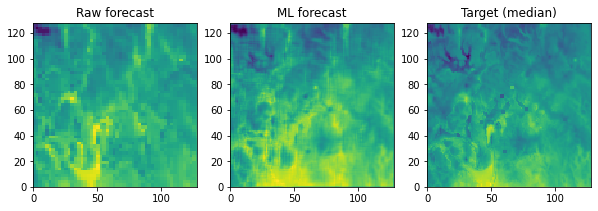

In [12]:
plt.subplot(1, 3, 1)
plt.pcolormesh(raw[0, :, :, 0])
plt.gca().set_aspect(1)
plt.title("Raw forecast")

plt.subplot(1, 3, 2)
plt.pcolormesh(output[0, :, :, 0])
plt.gca().set_aspect(1)
plt.title("ML forecast")

plt.subplot(1, 3, 3)
plt.pcolormesh(target[0, :, :, 0])
plt.gca().set_aspect(1)
plt.title("Target (median)")
plt.gcf().set_size_inches(10, 6)